## Problem 2 - Xianghui Gu

In [1]:
%matplotlib inline

### 2.0 Dateset

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


* reshape the data into num_img, length, width

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [4]:
print(x_train.shape,x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### 2.1 Create a modified training set

a. For each image in the train set, generate two images where the probability of a pixel value being flipped is 0.03

b. Your new training set size should be 120K

* reshape the image to array, so that it's easier to select 3% to be noise

In [5]:
x_train = np.reshape(x_train, (len(x_train), 28*28)) 
x_test = np.reshape(x_test, (len(x_test), 28*28))

* introduce noise to training set

In [6]:
import copy

np.random.seed(0)
flip_ratio = 0.03

num_img, area_img = x_train.shape

# generate random numbers, if lower than 0.03, flip it
noise_1 = np.random.rand(num_img, area_img)
noise_2 = np.random.rand(num_img, area_img)

noise_train_1 = copy.deepcopy(x_train)
noise_train_2 = copy.deepcopy(x_train)

noise_train_1[np.where(noise_1 <= flip_ratio)] = 1 - noise_train_1[np.where(noise_1 <= flip_ratio)]
noise_train_2[np.where(noise_2 <= flip_ratio)] = 1 - noise_train_2[np.where(noise_2 <= flip_ratio)]
    
noise_train_1 = np.reshape(noise_train_1, (len(x_train), 28, 28)) 
noise_train_2 = np.reshape(noise_train_2, (len(x_train), 28, 28)) 

In [7]:
noise_train = np.append(noise_train_1 , noise_train_2)
clean_train = np.append(x_train , x_train)

In [8]:
noise_train = np.reshape(noise_train, (len(x_train)*2, 28, 28, 1)) 
clean_train = np.reshape(clean_train, (len(x_train)*2, 28, 28, 1)) 

* introduce noise to testing set

In [9]:
noise_3 = np.random.rand(num_img, area_img)

noise_test = copy.deepcopy(x_train)

noise_test[np.where(noise_3 <= flip_ratio)] = 1 - noise_test[np.where(noise_3 <= flip_ratio)]

noise_test = np.reshape(noise_test, (len(x_test), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

ValueError: cannot reshape array of size 47040000 into shape (10000,28,28,1)

### 2.2 Convolutional autoencoder (four times)

a. Vary the CNN architecture in four ways

b. Optimize as best as possible during training


The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [150]:
from sklearn.metrics import mean_squared_error
def computeError(dec, x):
    errorlist = []
    for i in range(len(x)):
        temp = mean_squared_error(dec[i].reshape([28,28]), x[i].reshape([28,28]))
        errorlist.append((temp,i))
    errorlist.sort()
    return errorlist

### a. auto-encoder no.1 (epoch = 3)

In [11]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)
encoded_input = Input(shape=(4,4,8))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder1 = Model(input_img, decoded)
_decoder = Model(encoded_input, decoded)
autoencoder1.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])

# select 10% for training
small_ratio = 0.1
small_ind = np.random.choice(len(noise_train), int(len(noise_train)*small_ratio), replace = False)

noise_small = noise_train[small_ind]
clean_small = clean_train[small_ind]

history1 = autoencoder1.fit(noise_small, clean_small,
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_data=(noise_small, clean_small))

(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 8)
(?, 7, 7, 8)
(?, 7, 7, 8)
(?, 4, 4, 8)
(?, 4, 4, 8)
(?, 8, 8, 8)
(?, 8, 8, 8)
(?, 14, 14, 16)
(?, 28, 28, 16)


RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("input_2:0", shape=(?, 28, 28, 1), dtype=float32) at layer "input_2". The following previous layers were accessed without issue: []

In [136]:
predict1 = autoencoder1.predict(noise_test)
type(predict1)

numpy.ndarray

In [151]:
mse1 = computeError(predict1, x_test)

Best 10:



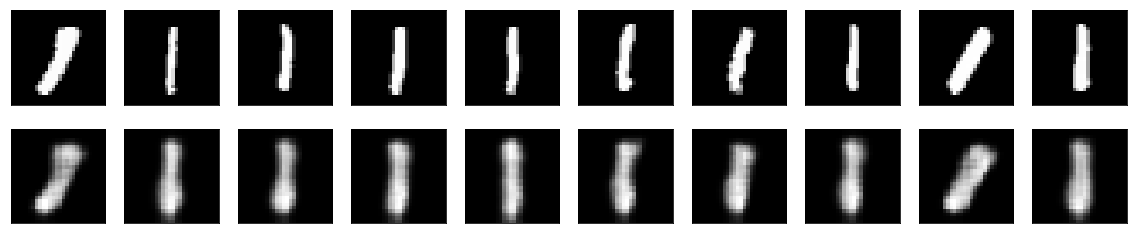

Worst 10:



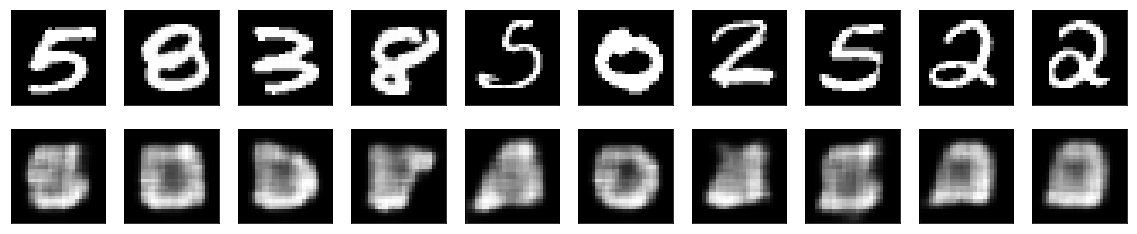

In [156]:
print("Best 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse1[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict1[mse1[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Worst 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse1[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict1[mse1[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

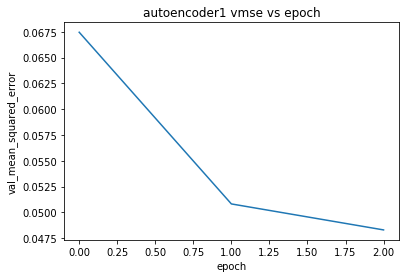

In [133]:
plt.plot(history1.history["val_mean_squared_error"])
plt.title('autoencoder1 vmse vs epoch')
plt.xlabel("epoch")
plt.ylabel("val_mean_squared_error")
plt.show()

### b. auto-encoder no.2 (epoch = 20)

In [157]:
autoencoder2 = Model(input_img, decoded)
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])

# select 10% for training
small_ratio = 0.1
small_ind = np.random.choice(len(noise_train), int(len(noise_train)*small_ratio), replace = False)

noise_small = noise_train[small_ind]
clean_small = clean_train[small_ind]

history2 = autoencoder2.fit(noise_small, clean_small,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(noise_test, x_test))

Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 26s - loss: 0.1906 - mean_squared_error: 0.0439 - val_loss: 0.1865 - val_mean_squared_error: 0.0425
Epoch 2/20
12000/12000 [==============================] - 23s - loss: 0.1830 - mean_squared_error: 0.0412 - val_loss: 0.1829 - val_mean_squared_error: 0.0414
Epoch 3/20
12000/12000 [==============================] - 22s - loss: 0.1782 - mean_squared_error: 0.0395 - val_loss: 0.1746 - val_mean_squared_error: 0.0382
Epoch 4/20
12000/12000 [==============================] - 24s - loss: 0.1733 - mean_squared_error: 0.0377 - val_loss: 0.1725 - val_mean_squared_error: 0.0377
Epoch 5/20
12000/12000 [==============================] - 22s - loss: 0.1685 - mean_squared_error: 0.0360 - val_loss: 0.1656 - val_mean_squared_error: 0.0351
Epoch 6/20
12000/12000 [==============================] - 22s - loss: 0.1654 - mean_squared_error: 0.0350 - val_loss: 0.1629 - val_mean_squared_error: 0.0342
Ep

In [159]:
predict2 = autoencoder2.predict(noise_test)
mse2 = computeError(predict2,x_test)

Best 10:



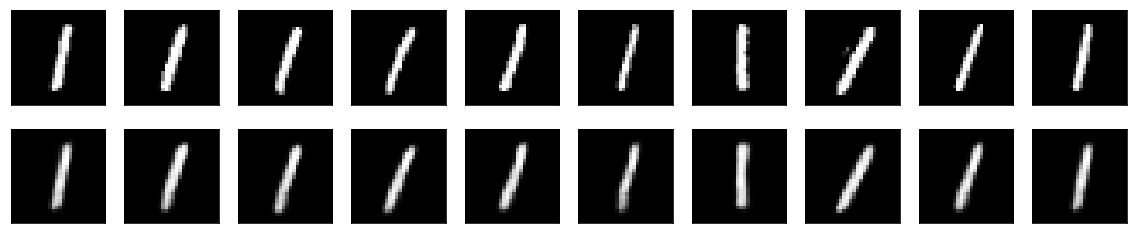

Worst 10:



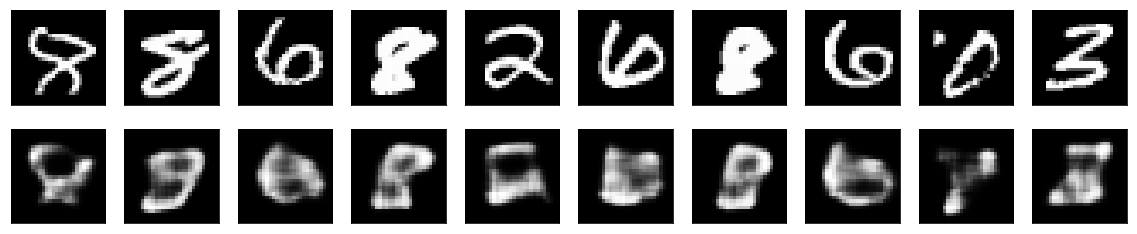

In [160]:
print("Best 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse2[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict2[mse2[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Worst 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse2[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict2[mse2[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

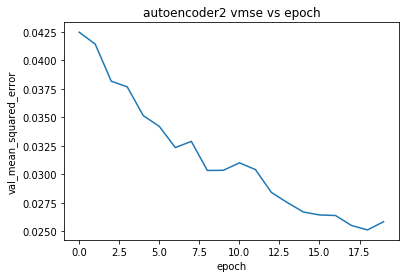

In [161]:
plt.plot(history2.history["val_mean_squared_error"])
plt.title('autoencoder2 vmse vs epoch')
plt.xlabel("epoch")
plt.ylabel("val_mean_squared_error")
plt.show()

### c. auto-encoder no.3 (epoch = 20, optimizer='rmsprop')

In [163]:
autoencoder3 = Model(input_img, decoded)
autoencoder3.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['mse'])

# select 10% for training
small_ratio = 0.1
small_ind = np.random.choice(len(noise_train), int(len(noise_train)*small_ratio), replace = False)

noise_small = noise_train[small_ind]
clean_small = clean_train[small_ind]

history3 = autoencoder3.fit(noise_small, clean_small,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(noise_test, x_test))

Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 29s - loss: 0.1421 - mean_squared_error: 0.0269 - val_loss: 0.1363 - val_mean_squared_error: 0.0250
Epoch 2/20
12000/12000 [==============================] - 26s - loss: 0.1389 - mean_squared_error: 0.0258 - val_loss: 0.1320 - val_mean_squared_error: 0.0234
Epoch 3/20
12000/12000 [==============================] - 25s - loss: 0.1373 - mean_squared_error: 0.0252 - val_loss: 0.1359 - val_mean_squared_error: 0.0247
Epoch 4/20
12000/12000 [==============================] - 23s - loss: 0.1355 - mean_squared_error: 0.0247 - val_loss: 0.1356 - val_mean_squared_error: 0.0249
Epoch 5/20
12000/12000 [==============================] - 25s - loss: 0.1339 - mean_squared_error: 0.0241 - val_loss: 0.1499 - val_mean_squared_error: 0.0302
Epoch 6/20
12000/12000 [==============================] - 23s - loss: 0.1334 - mean_squared_error: 0.0239 - val_loss: 0.1271 - val_mean_squared_error: 0.0218
Ep

In [164]:
predict3 = autoencoder3.predict(noise_test)
mse3 = computeError(predict3,x_test)

Best 10:



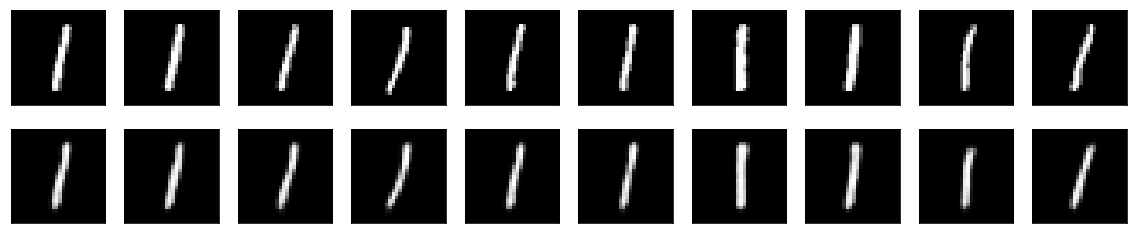

Worst 10:



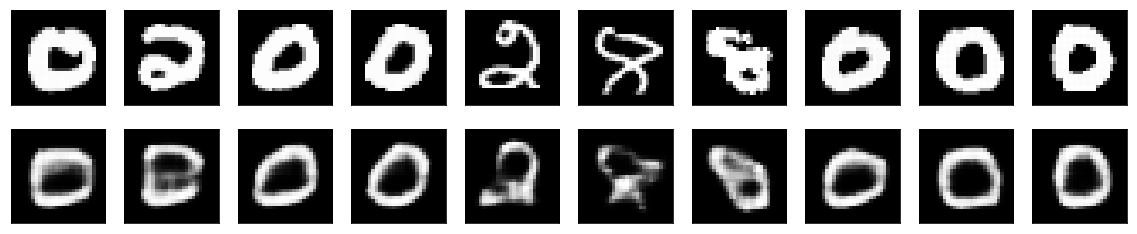

In [165]:
print("Best 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse3[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict3[mse3[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Worst 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse3[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict3[mse3[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

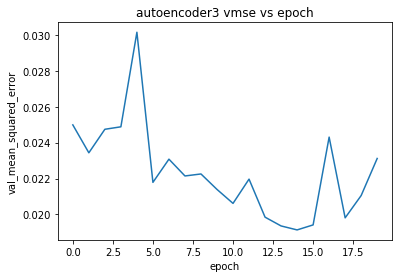

In [169]:
plt.plot(history3.history["val_mean_squared_error"])
plt.title('autoencoder3 vmse vs epoch')
plt.xlabel("epoch")
plt.ylabel("val_mean_squared_error")
plt.show()

### d. auto-encoder no.4 (epoch = 20, convolution: 32, 16, 16)

In [168]:
input_img = Input(shape=(28, 28, 1))

y = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
y = MaxPooling2D((2, 2), padding='same')(y)
y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D((2, 2), padding='same')(y)
y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
encoded = MaxPooling2D((2, 2), padding='same')(y)

y = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
y = UpSampling2D((2, 2))(y)
y = Conv2D(16, (3, 3), activation='relu', padding='same')(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(32, (3, 3), activation='relu')(y)
y = UpSampling2D((2, 2))(y)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)

autoencoder4 = Model(input_img, decoded)
autoencoder4.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse'])

# select 10% for training
small_ratio = 0.1
small_ind = np.random.choice(len(noise_train), int(len(noise_train)*small_ratio), replace = False)

noise_small = noise_train[small_ind]
clean_small = clean_train[small_ind]

history4 = autoencoder4.fit(noise_small, clean_small,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(noise_test, x_test))


Train on 12000 samples, validate on 10000 samples
Epoch 1/20
12000/12000 [==============================] - 44s - loss: 0.3371 - mean_squared_error: 0.0893 - val_loss: 0.2454 - val_mean_squared_error: 0.0611
Epoch 2/20
12000/12000 [==============================] - 39s - loss: 0.2185 - mean_squared_error: 0.0538 - val_loss: 0.2027 - val_mean_squared_error: 0.0481
Epoch 3/20
12000/12000 [==============================] - 39s - loss: 0.1927 - mean_squared_error: 0.0451 - val_loss: 0.1870 - val_mean_squared_error: 0.0434
Epoch 4/20
12000/12000 [==============================] - 41s - loss: 0.1768 - mean_squared_error: 0.0394 - val_loss: 0.1697 - val_mean_squared_error: 0.0371
Epoch 5/20
12000/12000 [==============================] - 41s - loss: 0.1655 - mean_squared_error: 0.0354 - val_loss: 0.1679 - val_mean_squared_error: 0.0358
Epoch 6/20
12000/12000 [==============================] - 40s - loss: 0.1568 - mean_squared_error: 0.0322 - val_loss: 0.1482 - val_mean_squared_error: 0.0289
Ep

In [170]:
predict4 = autoencoder4.predict(noise_test)
mse4 = computeError(predict4,x_test)

Best 10:



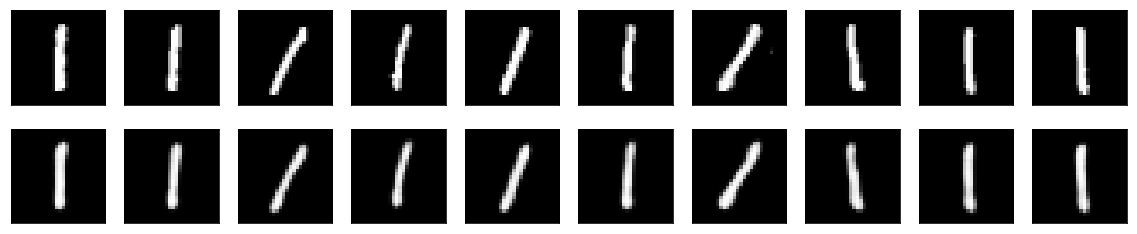

Worst 10:



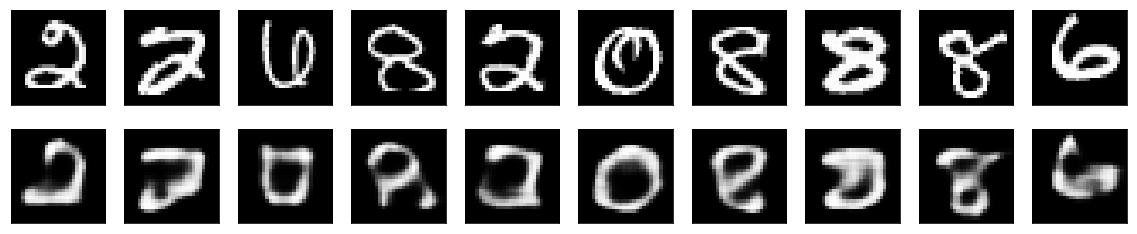

In [171]:
print("Best 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse4[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict4[mse4[i][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Worst 10:\n")
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[mse4[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(predict4[mse4[-i-1][1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

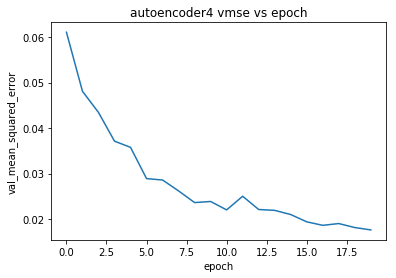

In [172]:
plt.plot(history4.history["val_mean_squared_error"])
plt.title('autoencoder4 vmse vs epoch')
plt.xlabel("epoch")
plt.ylabel("val_mean_squared_error")
plt.show()